In [1]:
import cv2 as cv
import scipy
import numpy
import math
import os
import random
from skimage import data, io, filters, restoration
from skimage.util import view_as_windows as viewW
from skimage.util import random_noise
from skimage.morphology import disk
from matplotlib import pyplot as plt
from deap import base, creator, tools, algorithms

In [2]:
import importlib
from util import performance_functions
from util.weak_texture_patches import noise_level, weak_texture_mask
from util.denoising_functions import *
importlib.reload(performance_functions)

<module 'util.performance_functions' from '/home/sam/Documents/Notes/FourthYearProject/util/performance_functions.py'>

# Image denoising using Weak Texture Patches and Genetic Algorithms

## Weak Texture Patch Generation

In [3]:
# Loading in an example image and reversing the color channels to match the standard case
example_image = cv.imread('images/18.jpg')
example_image = example_image[:,:,::-1]

plt.rcParams["figure.figsize"]=10,10

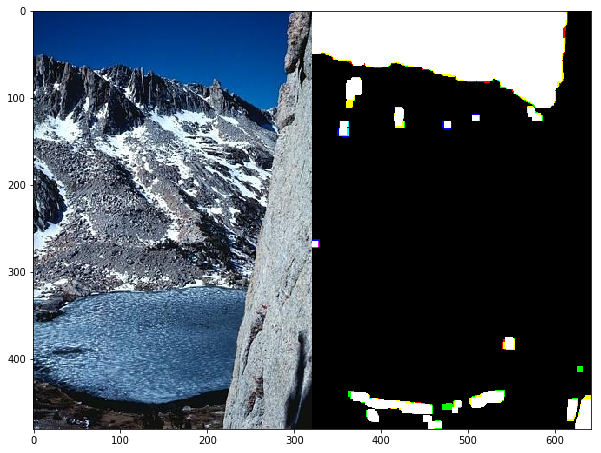

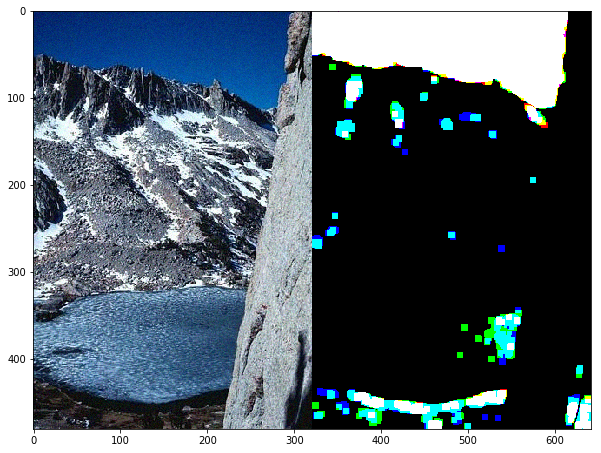

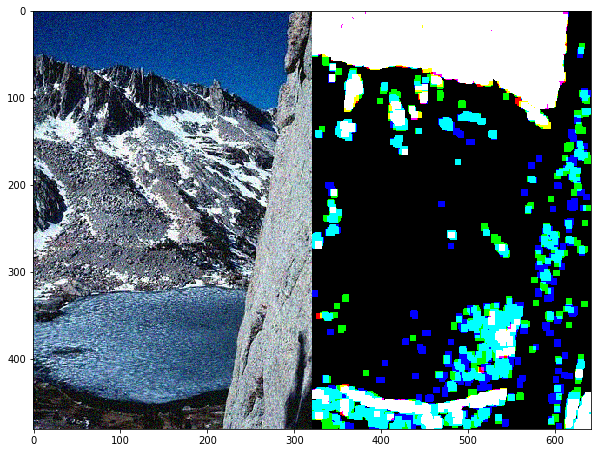

In [4]:
nlevel, th, num = noise_level(example_image)
example_image_mask = weak_texture_mask(example_image, th )
disp1 = numpy.hstack((example_image,example_image_mask.astype(numpy.uint8) * 255))
plt.imshow(disp1)
plt.show()

noisy_image = random_noise(example_image, mode="gaussian", var=0.001)
nlevel, th, num = noise_level(noisy_image, conf = 0.97)
noisy_image_mask = weak_texture_mask(noisy_image, th)
disp2 = numpy.hstack((noisy_image* 255,noisy_image_mask * 255)).astype(numpy.uint8)
plt.imshow(disp2)
plt.show()

noisier_image = random_noise(example_image, mode="gaussian", var=0.005)
nlevel, th, num = noise_level(noisier_image, conf = 0.90)
noisier_image_mask = weak_texture_mask(noisier_image, th)
disp2 = numpy.hstack((noisier_image* 255,noisier_image_mask * 255)).astype(numpy.uint8)
plt.imshow(disp2)
plt.show()

-------------
RMSE when applying no denoising algorithm:  13.607146010897674
RMSE after applying denoising algorithm:  10.84384642332031
RMSE when applying just the filter used on the weak patch:  55.525779785947215
RMSE when applying just the filter used on the rich patch:  12.485221434017125
RMSE when applying just a gaussian blur:  11.938637765254049
-------------


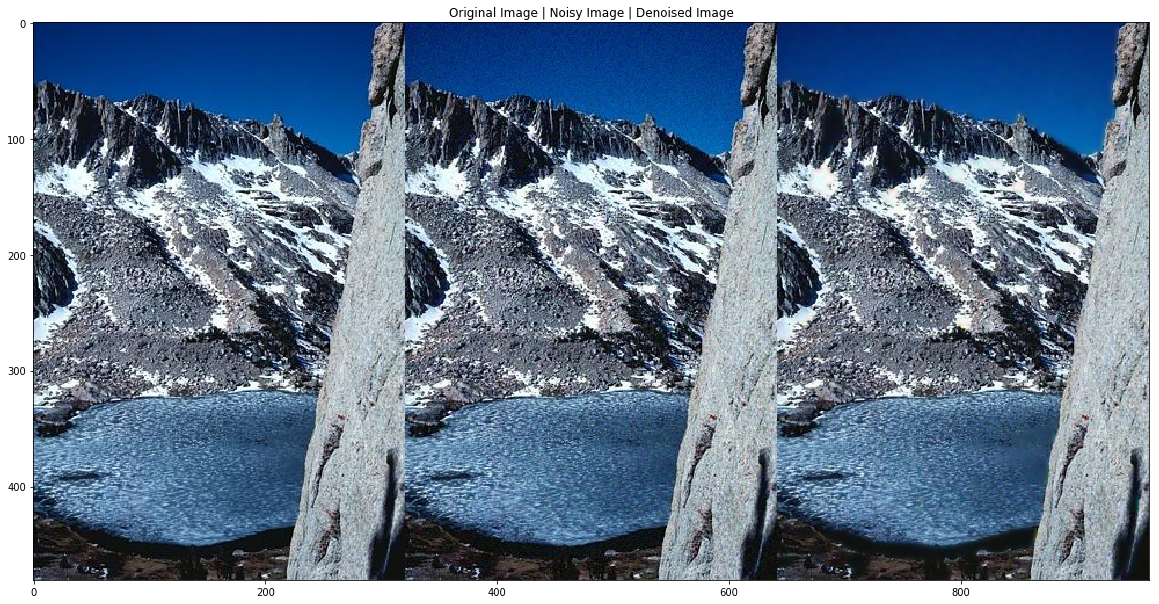

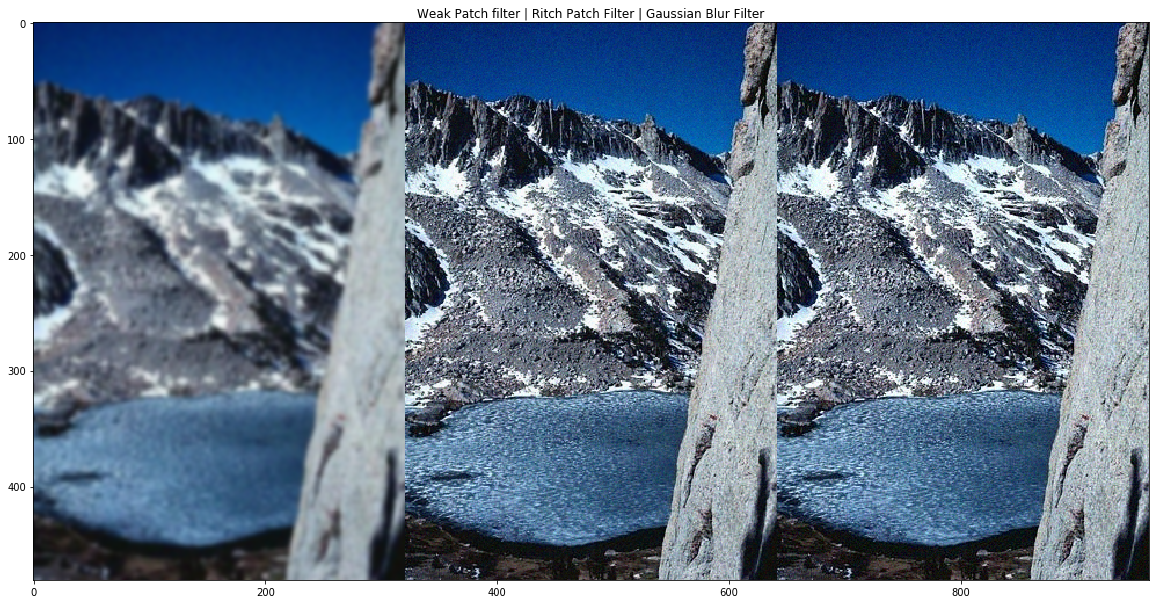

In [18]:
plt.rcParams["figure.figsize"]=20,20

denoised_example_image_weak = filters.gaussian(noisy_image, sigma=2)#restoration.denoise_tv_chambolle(noisy_image, weight=0.03)
denoised_example_image_rich = restoration.denoise_tv_chambolle(noisy_image, weight=0.005)

gaussian_blur_denoised_image = (filters.gaussian(noisy_image, sigma=0.1) * 255).astype(numpy.uint8)

weak_texture = (denoised_example_image_weak * noisy_image_mask)
strong_texture = (denoised_example_image_rich - (denoised_example_image_rich * noisy_image_mask))

denoised_image = weak_texture + strong_texture
denoised_image = (denoised_image * 255).astype(numpy.uint8)

baseline = performance_functions.root_mean_squared_error(example_image, noisy_image*255)
test_fitness = performance_functions.root_mean_squared_error(example_image, denoised_image)

fitness_single_filter_weak = performance_functions.root_mean_squared_error(example_image, \
                                                                           denoised_example_image_weak*255)
fitness_single_filter_rich = performance_functions.root_mean_squared_error(example_image, \
                                                                           denoised_example_image_rich*255)
fitness_just_gaussian_blur =  performance_functions.root_mean_squared_error(example_image, \
                                                                           gaussian_blur_denoised_image)

print("-------------")
print("RMSE when applying no denoising algorithm: ",baseline)
print("RMSE after applying denoising algorithm: ", test_fitness)
print("RMSE when applying just the filter used on the weak patch: ",fitness_single_filter_weak)
print("RMSE when applying just the filter used on the rich patch: ", fitness_single_filter_rich)
print("RMSE when applying just a gaussian blur: ", fitness_just_gaussian_blur)
print("-------------")

all_images_merged = numpy.hstack((example_image,noisy_image*255,denoised_image)).astype(numpy.uint8)
plt.imshow(all_images_merged)
plt.title("Original Image | Noisy Image | Denoised Image")
plt.show()

other_filters_merged = numpy.hstack((denoised_example_image_weak*255, \
                                     denoised_example_image_rich*255, \
                                     gaussian_blur_denoised_image)).astype(numpy.uint8)
plt.imshow(other_filters_merged)
plt.title("Weak Patch filter | Ritch Patch Filter | Gaussian Blur Filter")
plt.show()

## Generating the Image Dataset

In [6]:
import sys
class ImageDataset:
    
    def __init__(self, size, sigma=0.0002):
        self.dir_location = "images/"
        self.base_images = []
        self.noisy_images = []
        self.weak_texture_masks = []
        self.noise_levels = []
        self.sigma = sigma
        self.load_files(size)
        
        
    def load_files(self, size):
        self.base_images = []
        for i in range(1,size+1) :
            image_name = str(i) + ".jpg"
            new_image = cv.imread(self.dir_location+image_name);
            new_image = new_image[:,:,::-1]
            self.base_images += [new_image]
            noisy_image = random_noise(new_image, mode="gaussian", var=self.sigma)
            
            self.noisy_images += [noisy_image]
            try:
                nlevel, th, num = noise_level(noisy_image, conf=0.97)
                self.noise_levels += [nlevel]
                new_image_mask = weak_texture_mask(noisy_image,th)
                self.weak_texture_masks += [new_image_mask]
            except Exception as e:
                print(e)
                plt.imshow(new_image)
                plt.show()
            
            
            
        

In [7]:
images = ImageDataset(2,0.0005)

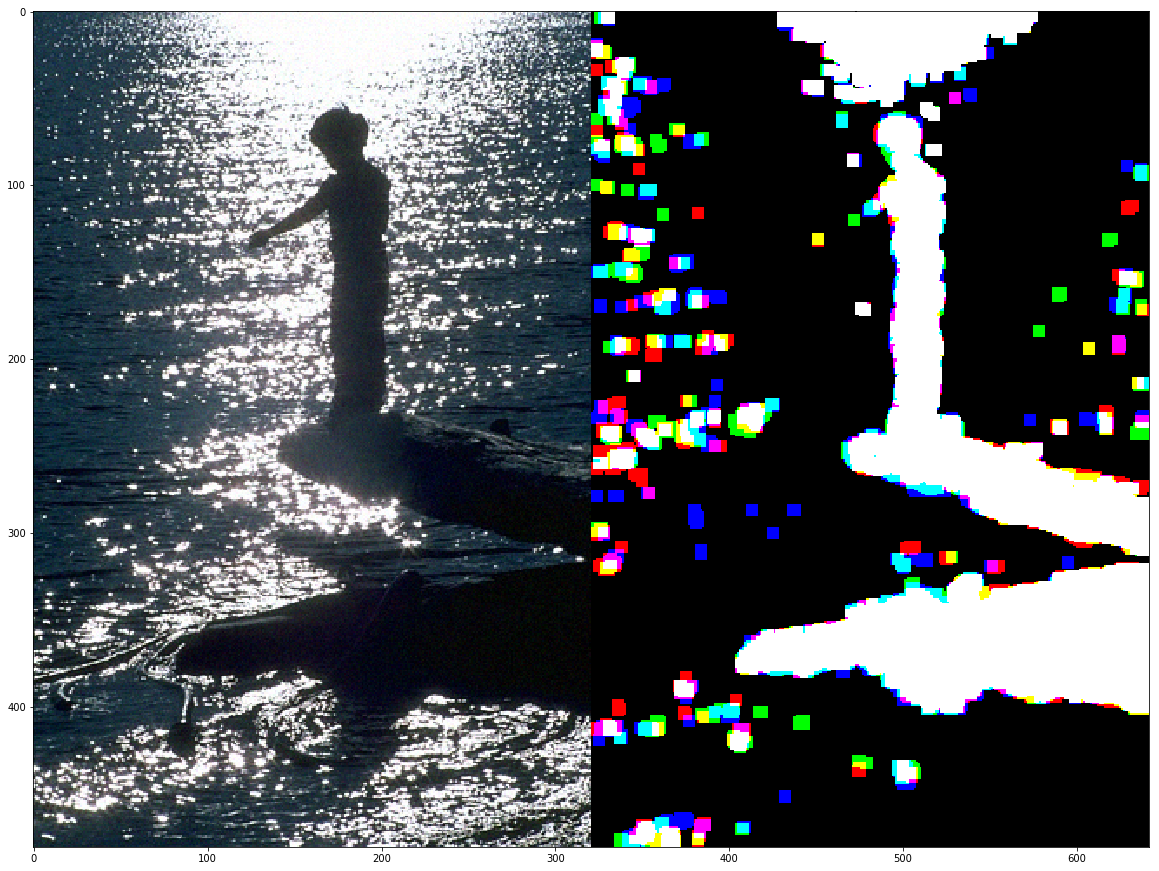

In [8]:
img_and_mask = numpy.hstack((images.noisy_images[0]*255,images.weak_texture_masks[0]*255)).astype(numpy.uint8)
plt.imshow(img_and_mask)
plt.show()

## 

| Action Map | Texture Type |
| --- | --- |
| 0 | Weak Texture Filter |
| 1 | Rich Texture Filter |

## Actions

| Action ID | Action |
| --- | --- |
| 0 | Gaussian Blur with Sigma = 0.01 | 
| 1 | Gaussian Blur with Sigma = 0.02 |
| 2 | Gaussian Blur with Sigma = 0.03 |
| 3 | Gaussian Blur with Sigma = 0.04 |
| 4 | Chambolle TV Filter with Weight = 0.02 | 
| 5 | Chambolle TV Filter with Weight = 0.01 |
| 6 | Chambolle TV Filter with Weight = 0.005 |
| 7 | Chambolle TV Filter with Weight = 0.001 |

In [9]:
import random
from deap import algorithms, base, creator, tools

NUM_FILTERS = 8
SIZE_OF_INDIVIDUAL = math.ceil(math.log2(NUM_FILTERS**2))

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

evaluation = lambda i : evaluate(i, images)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=SIZE_OF_INDIVIDUAL)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluation)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=40)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=False)

print(tools.selBest(pop, k=1)[0])

[1, 0, 1, 1, 1, 0]


PSNR: 34.573386
 IQI: 0.999712
 SSIM: 0.967322



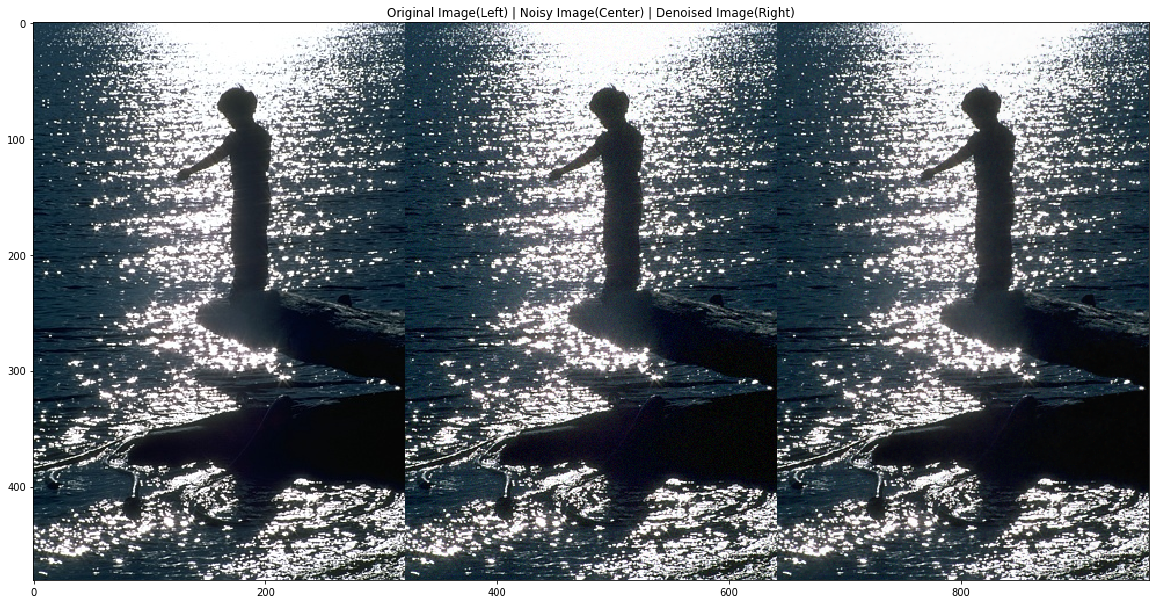

(8.1182920070833,)


In [10]:
print(evaluate(tools.selBest(pop, k=1)[0], images, True))

In [11]:
def compare_results(individual):
    test_image_rmse = evaluate(individual, images, True)
    new_image_rmse = evaluate(individual, images, True, 1)
    print("Test Image RMSE: %f \nUnseen Image RMSE: %f"%(test_image_rmse[0], new_image_rmse[0]))
    print("Test Image Estimated Noise:", images.noise_levels[0])
    print("Unseen Image Estimated Noise:", images.noise_levels[1])

PSNR: 34.573386
 IQI: 0.999712
 SSIM: 0.967322



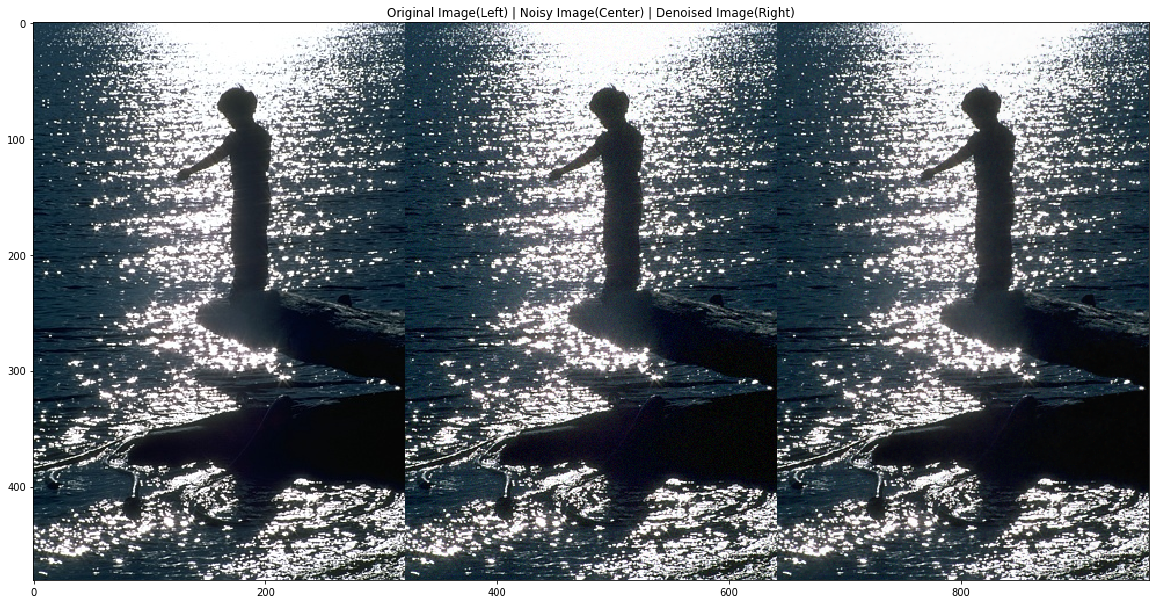

PSNR: 37.869873
 IQI: 0.998844
 SSIM: 0.940175



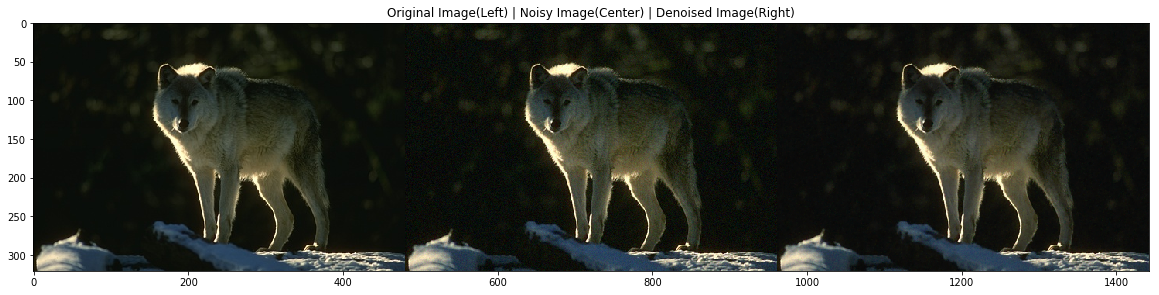

Test Image RMSE: 8.118292 
Unseen Image RMSE: 5.622777
Test Image Estimated Noise: [0.018165429766273722, 0.01927656099528438, 0.01997110132086242]
Unseen Image Estimated Noise: [0.02090834382223088, 0.021171089574944187, 0.020587486596464123]


In [12]:
compare_results(tools.selBest(pop, k=1)[0])